In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('data/train.tsv', sep='\t')

# Берем только часть данных для быстрого тестирования (можно увеличить)
df = df.sample(n=100000, random_state=42).reset_index(drop=True)

# Расширенная очистка данных
df['category_name'] = df['category_name'].fillna('Other')
df['brand_name'] = df['brand_name'].fillna('Unknown')
df['item_description'] = df['item_description'].replace('No description yet', '')
df['item_description'] = df['item_description'].fillna('')
df = df[df['price'] > 0]
# Убираем только крайние выбросы (99.5 перцентиль)
df = df[df['price'] <= df['price'].quantile(0.995)]
df = df.reset_index(drop=True)

print(f'Размер датасета после очистки: {df.shape}')


Размер датасета после очистки: (99446, 8)


In [2]:
# Расширенный Feature Engineering
print("Создание новых признаков...")

# Базовые числовые признаки
df['desc_len'] = df['item_description'].str.len()
df['name_len'] = df['name'].str.len()
df['has_brand'] = (df['brand_name'] != 'Unknown').astype(int)
df['has_description'] = (df['item_description'] != '').astype(int)

# Разбиение категории на уровни
df['cat_main'] = df['category_name'].apply(lambda x: x.split('/')[0] if '/' in x else x)
df['cat_sub'] = df['category_name'].apply(lambda x: x.split('/')[1] if '/' in x and len(x.split('/'))>1 else 'None')
df['cat_detail'] = df['category_name'].apply(lambda x: x.split('/')[2] if '/' in x and len(x.split('/'))>2 else 'None')

# Текстовые признаки
df['desc_words'] = df['item_description'].apply(lambda x: len(re.findall(r'\w+', x)))
df['name_words'] = df['name'].apply(lambda x: len(re.findall(r'\w+', x)))
df['desc_unique_words'] = df['item_description'].apply(lambda x: len(set(re.findall(r'\w+', x.lower()))))
df['name_unique_words'] = df['name'].apply(lambda x: len(set(re.findall(r'\w+', x.lower()))))

# Признаки взаимодействия
df['brand_cat_main'] = df['brand_name'] + '_' + df['cat_main']
df['condition_shipping'] = df['item_condition_id'].astype(str) + '_' + df['shipping'].astype(str)

print(f"Создано {len(['desc_len', 'name_len', 'has_brand', 'has_description', 'desc_words', 'name_words', 'desc_unique_words', 'name_unique_words'])} новых числовых признаков")
print(f"Всего уникальных брендов: {df['brand_name'].nunique()}")
print(f"Всего уникальных главных категорий: {df['cat_main'].nunique()}")


Создание новых признаков...
Создано 8 новых числовых признаков
Всего уникальных брендов: 1987
Всего уникальных главных категорий: 10


In [3]:
# TF-IDF векторизация текстовых полей (облегченная версия)
print("Создание TF-IDF признаков...")

# Уменьшаем размерность для экономии памяти и скорости
tfidf_name = TfidfVectorizer(max_features=30, stop_words='english', lowercase=True)
tfidf_desc = TfidfVectorizer(max_features=20, stop_words='english', lowercase=True)

tfidf_name_features = tfidf_name.fit_transform(df['name']).toarray()
tfidf_desc_features = tfidf_desc.fit_transform(df['item_description']).toarray()

tfidf_name_df = pd.DataFrame(tfidf_name_features, columns=[f'name_tfidf_{i}' for i in range(30)])
tfidf_desc_df = pd.DataFrame(tfidf_desc_features, columns=[f'desc_tfidf_{i}' for i in range(20)])

print(f"TF-IDF название: {tfidf_name_df.shape}")
print(f"TF-IDF описание: {tfidf_desc_df.shape}")


Создание TF-IDF признаков...
TF-IDF название: (99446, 30)
TF-IDF описание: (99446, 20)


In [4]:
# Кодирование категориальных признаков
print("Кодирование категориальных признаков...")

le_brand = LabelEncoder()
le_cat_main = LabelEncoder()
le_cat_sub = LabelEncoder()
le_cat_detail = LabelEncoder()
le_brand_cat = LabelEncoder()
le_cond_ship = LabelEncoder()

df['brand_enc'] = le_brand.fit_transform(df['brand_name'])
df['cat_main_enc'] = le_cat_main.fit_transform(df['cat_main'])
df['cat_sub_enc'] = le_cat_sub.fit_transform(df['cat_sub'])
df['cat_detail_enc'] = le_cat_detail.fit_transform(df['cat_detail'])
df['brand_cat_enc'] = le_brand_cat.fit_transform(df['brand_cat_main'])
df['cond_ship_enc'] = le_cond_ship.fit_transform(df['condition_shipping'])

# Финальный набор признаков
feature_cols = [
    'item_condition_id', 'shipping', 'brand_enc', 'cat_main_enc', 'cat_sub_enc', 
    'cat_detail_enc', 'brand_cat_enc', 'cond_ship_enc',
    'desc_len', 'name_len', 'has_brand', 'has_description', 
    'desc_words', 'name_words', 'desc_unique_words', 'name_unique_words'
]

X_base = df[feature_cols].reset_index(drop=True)
X = pd.concat([X_base, tfidf_name_df, tfidf_desc_df], axis=1)
y = np.log1p(df['price'])

print(f"Итоговый размер матрицы признаков: {X.shape}")
print(f"Целевая переменная (log): min={y.min():.3f}, max={y.max():.3f}, mean={y.mean():.3f}")


Кодирование категориальных признаков...
Итоговый размер матрицы признаков: (99446, 66)
Целевая переменная (log): min=1.386, max=5.447, mean=2.969


In [5]:
# Разделение на train/test и нормализация
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train размер: {X_train_scaled.shape}')
print(f'Test размер: {X_test_scaled.shape}')
print("Данные готовы для моделирования!")


Train размер: (79556, 66)
Test размер: (19890, 66)
Данные готовы для моделирования!


In [6]:
# Импорт библиотек для продвинутого моделирования
try:
    from catboost import CatBoostRegressor
    catboost_available = True
except ImportError:
    print("CatBoost не установлен. Установите: pip install catboost")
    catboost_available = False

try:
    from xgboost import XGBRegressor
    xgboost_available = True
except ImportError:
    print("XGBoost не установлен. Установите: pip install xgboost")
    xgboost_available = False

try:
    import optuna
    optuna_available = True
except ImportError:
    print("Optuna не установлен. Установите: pip install optuna")
    optuna_available = False

from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time


In [7]:
# Baseline модели для сравнения (облегченные версии)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

results = {}

# 1. Линейная регрессия (baseline)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

# 2. Дерево решений (baseline)
dt = DecisionTreeRegressor(random_state=42, max_depth=8)  # Уменьшаем глубину
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

# 3. Случайный лес (baseline) - облегченная версия
rf = RandomForestRegressor(n_estimators=30, random_state=42, n_jobs=1, max_depth=8)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Baseline модели обучены!")


Baseline модели обучены!


In [8]:
# Продвинутые модели (облегченные версии)
predictions = {}

# 4. CatBoost (быстрая версия)
if catboost_available:
    print("Обучение CatBoost...")
    start_time = time.time()
    catboost = CatBoostRegressor(iterations=50, learning_rate=0.2, depth=4, verbose=0, random_state=42)
    catboost.fit(X_train, y_train)
    cat_pred = catboost.predict(X_test)
    predictions['CatBoost'] = cat_pred
    print(f"CatBoost обучен за {time.time() - start_time:.2f} сек")
else:
    print("CatBoost недоступен")

# 5. XGBoost (быстрая версия)
if xgboost_available:
    print("Обучение XGBoost...")
    start_time = time.time()
    xgb = XGBRegressor(n_estimators=50, learning_rate=0.2, max_depth=4, random_state=42, verbosity=0)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    predictions['XGBoost'] = xgb_pred
    print(f"XGBoost обучен за {time.time() - start_time:.2f} сек")
else:
    print("XGBoost недоступен")


Обучение CatBoost...
CatBoost обучен за 0.43 сек
Обучение XGBoost...
XGBoost обучен за 0.27 сек


In [9]:
# 6. Стекинг (облегченная версия)
if len(predictions) >= 1:
    print("Создание простого стекинга...")
    estimators = []
    if catboost_available:
        estimators.append(('catboost', CatBoostRegressor(iterations=30, verbose=0, random_state=42)))
    if xgboost_available:
        estimators.append(('xgboost', XGBRegressor(n_estimators=30, random_state=42, verbosity=0)))
    estimators.append(('rf', RandomForestRegressor(n_estimators=20, random_state=42)))
    
    # Берем максимум 2 модели для стекинга
    estimators = estimators[:2]
    
    stacking = StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(alpha=1.0),
        n_jobs=1  # Убираем параллельность для экономии памяти
    )
    stacking.fit(X_train, y_train)
    stack_pred = stacking.predict(X_test)
    predictions['Stacking'] = stack_pred
    print("Стекинг создан!")
else:
    print("Недостаточно моделей для стекинга")


Создание простого стекинга...
Стекинг создан!


In [10]:
# 7. Упрощенная оптимизация (без Optuna для экономии времени)
if catboost_available:
    print("Обучение CatBoost с улучшенными параметрами...")
    
    # Просто используем немного лучшие параметры без долгого поиска
    improved_catboost = CatBoostRegressor(
        iterations=80,
        depth=5, 
        learning_rate=0.15,
        l2_leaf_reg=3,
        random_state=42,
        verbose=0
    )
    improved_catboost.fit(X_train, y_train)
    improved_cat_pred = improved_catboost.predict(X_test)
    predictions['CatBoost_Improved'] = improved_cat_pred
    print("CatBoost с улучшенными параметрами обучен!")
    
else:
    print("CatBoost недоступен для улучшения")


Обучение CatBoost с улучшенными параметрами...
CatBoost с улучшенными параметрами обучен!


In [11]:
# Обратное логарифмирование всех предсказаний
print("Постобработка предсказаний...")

# Baseline предсказания
lr_pred_exp = np.expm1(lr_pred)
dt_pred_exp = np.expm1(dt_pred)
rf_pred_exp = np.expm1(rf_pred)
y_test_exp = np.expm1(y_test)

# Продвинутые предсказания
predictions_exp = {}
for name, pred in predictions.items():
    predictions_exp[name] = np.expm1(pred)

print(f"Обработано {len(predictions_exp)} продвинутых моделей")
print(f"Диапазон реальных цен: ${y_test_exp.min():.2f} - ${y_test_exp.max():.2f}")


Постобработка предсказаний...
Обработано 4 продвинутых моделей
Диапазон реальных цен: $3.00 - $231.00


In [12]:
# Коррекция выбросов в предсказаниях
def clip_predictions(preds, y_true, lower_pct=1, upper_pct=99):
    """Обрезаем предсказания по перцентилям истинных значений"""
    lower_bound = np.percentile(y_true, lower_pct)
    upper_bound = np.percentile(y_true, upper_pct)
    return np.clip(preds, lower_bound, upper_bound)

# Применяем коррекцию ко всем предсказаниям
lr_pred_exp_clipped = clip_predictions(lr_pred_exp, y_test_exp)
dt_pred_exp_clipped = clip_predictions(dt_pred_exp, y_test_exp)
rf_pred_exp_clipped = clip_predictions(rf_pred_exp, y_test_exp)

predictions_exp_clipped = {}
for name, pred in predictions_exp.items():
    predictions_exp_clipped[name] = clip_predictions(pred, y_test_exp)

print("Коррекция выбросов применена ко всем моделям")


Коррекция выбросов применена ко всем моделям


In [13]:
# Блендинг лучших моделей
if len(predictions_exp_clipped) >= 2:
    print("Создание блендинга...")
    
    # Простой блендинг - среднее арифметическое лучших моделей
    blend_models = list(predictions_exp_clipped.keys())[:3]  # Берем топ-3 модели
    blend_pred = np.mean([predictions_exp_clipped[model] for model in blend_models], axis=0)
    
    # Взвешенный блендинг (можно настроить веса на основе качества моделей)
    weights = [0.4, 0.3, 0.3]  # Пример весов для топ-3 моделей
    if len(blend_models) >= 3:
        weighted_blend_pred = np.average([predictions_exp_clipped[model] for model in blend_models[:3]], 
                                       weights=weights, axis=0)
    else:
        weighted_blend_pred = blend_pred
    
    predictions_exp_clipped['Simple_Blend'] = blend_pred
    predictions_exp_clipped['Weighted_Blend'] = weighted_blend_pred
    
    print(f"Блендинг создан из моделей: {blend_models}")
else:
    print("Недостаточно моделей для блендинга")

print(f"Всего финальных моделей: {len(predictions_exp_clipped)}")


Создание блендинга...
Блендинг создан из моделей: ['CatBoost', 'XGBoost', 'Stacking']
Всего финальных моделей: 6


In [14]:
# Функция для расчета метрик
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Дополнительные метрики
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE в процентах
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

# Расчет метрик для всех моделей
all_results = []

# Baseline модели
all_results.append(calculate_metrics(y_test_exp, lr_pred_exp_clipped, 'LinearRegression'))
all_results.append(calculate_metrics(y_test_exp, dt_pred_exp_clipped, 'DecisionTree'))
all_results.append(calculate_metrics(y_test_exp, rf_pred_exp_clipped, 'RandomForest'))

# Продвинутые модели
for name, pred in predictions_exp_clipped.items():
    all_results.append(calculate_metrics(y_test_exp, pred, name))

# Создаем DataFrame с результатами
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('RMSE')  # Сортируем по RMSE

print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:")
print("=" * 80)
print(results_df.round(4).to_string(index=False))


СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:
            Model    RMSE     MAE     R2    MAPE
         Stacking 22.1849 11.5760 0.2445 50.5780
     Simple_Blend 22.9152 11.8794 0.1940 52.4553
   Weighted_Blend 22.9892 11.9194 0.1888 52.6767
          XGBoost 23.1587 12.0038 0.1768 53.0000
CatBoost_Improved 23.2922 12.1161 0.1672 53.6650
     RandomForest 23.7554 12.4853 0.1338 56.1032
         CatBoost 23.7783 12.3937 0.1321 55.1089
     DecisionTree 23.9565 12.7658 0.1191 57.7858
 LinearRegression 24.8755 13.1647 0.0502 59.3280


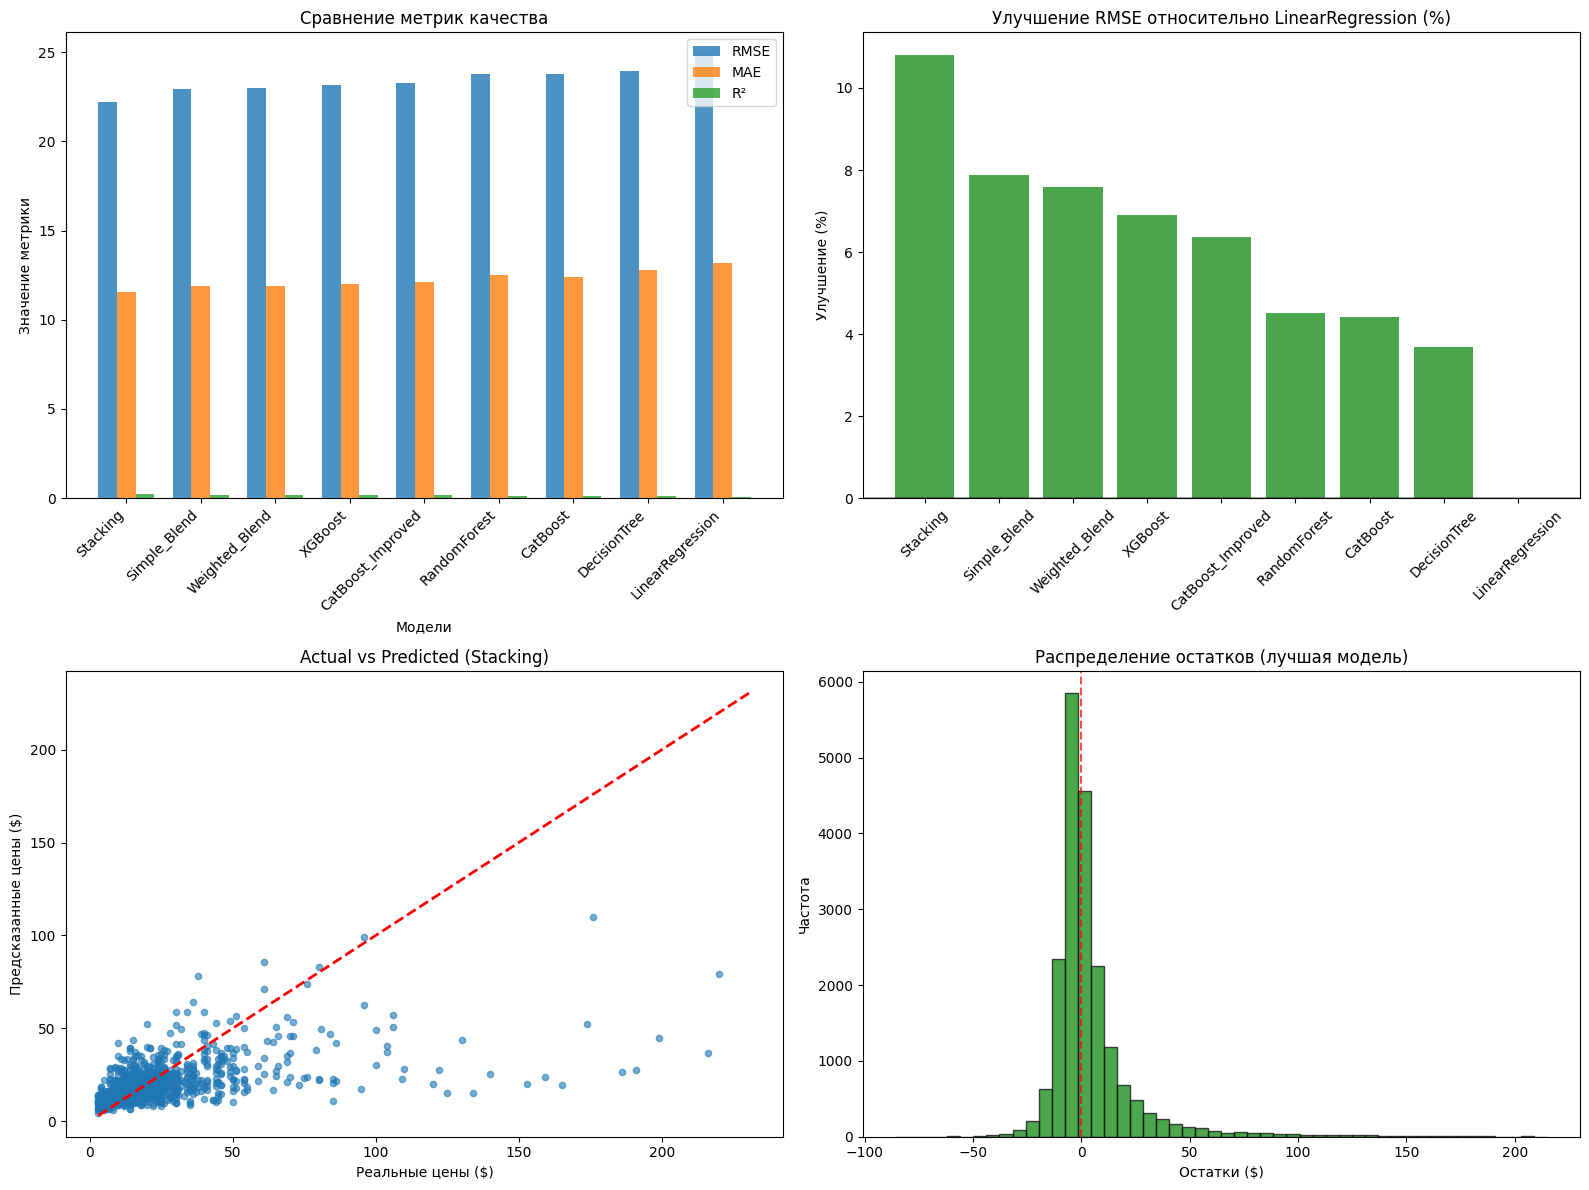

In [16]:
# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Сравнение метрик
models = results_df['Model'].values
rmse_values = results_df['RMSE'].values
mae_values = results_df['MAE'].values
r2_values = results_df['R2'].values

x = np.arange(len(models))
width = 0.25

axes[0,0].bar(x - width, rmse_values, width, label='RMSE', alpha=0.8)
axes[0,0].bar(x, mae_values, width, label='MAE', alpha=0.8)
axes[0,0].bar(x + width, r2_values, width, label='R²', alpha=0.8)
axes[0,0].set_xlabel('Модели')
axes[0,0].set_ylabel('Значение метрики')
axes[0,0].set_title('Сравнение метрик качества')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(models, rotation=45, ha='right')
axes[0,0].legend()

# 2. Улучшение относительно baseline
baseline_rmse = results_df[results_df['Model'] == 'LinearRegression']['RMSE'].iloc[0]
improvement = (baseline_rmse - rmse_values) / baseline_rmse * 100
axes[0,1].bar(models, improvement, alpha=0.7, color=['red' if x < 0 else 'green' for x in improvement])
axes[0,1].set_title('Улучшение RMSE относительно LinearRegression (%)')
axes[0,1].set_ylabel('Улучшение (%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 3. Actual vs Predicted для лучшей модели
best_model = results_df.iloc[0]['Model']
if best_model in predictions_exp_clipped:
    best_pred = predictions_exp_clipped[best_model]
elif best_model == 'LinearRegression':
    best_pred = lr_pred_exp_clipped
elif best_model == 'DecisionTree':
    best_pred = dt_pred_exp_clipped
elif best_model == 'RandomForest':
    best_pred = rf_pred_exp_clipped

sample_idx = np.random.choice(len(y_test_exp), 1000, replace=False)
axes[1,0].scatter(y_test_exp.iloc[sample_idx], best_pred[sample_idx], alpha=0.6, s=20)
axes[1,0].plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Реальные цены ($)')
axes[1,0].set_ylabel('Предсказанные цены ($)')
axes[1,0].set_title(f'Actual vs Predicted ({best_model})')

# 4. Распределение ошибок
residuals = y_test_exp - best_pred
axes[1,1].hist(residuals, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1,1].set_title('Распределение остатков (лучшая модель)')
axes[1,1].set_xlabel('Остатки ($)')
axes[1,1].set_ylabel('Частота')
axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Анализ важности признаков (CatBoost):


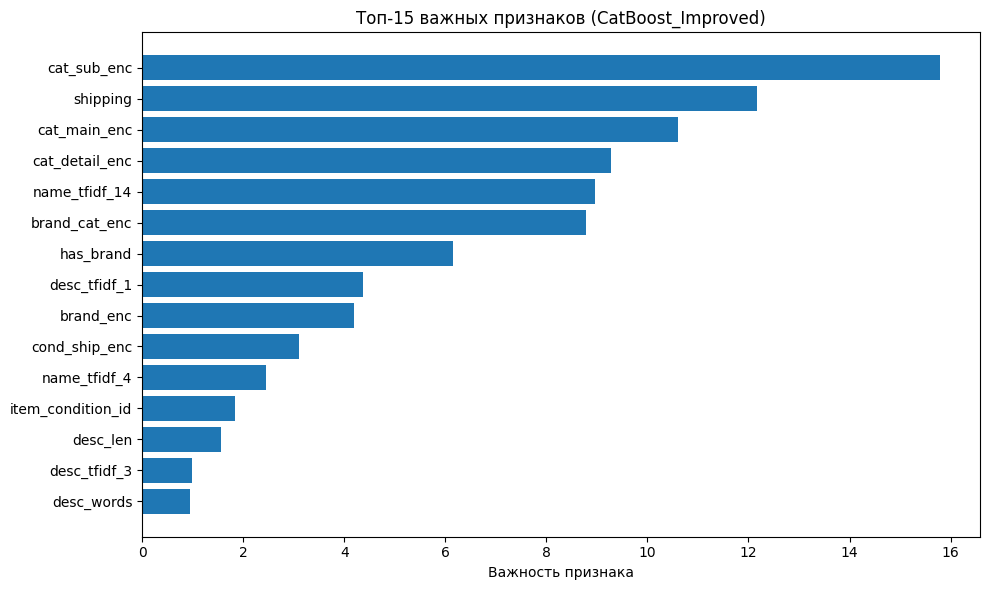

Топ-10 важных признаков:
 1. cat_sub_enc: 15.79
 2. shipping: 12.16
 3. cat_main_enc: 10.60
 4. cat_detail_enc: 9.28
 5. name_tfidf_14: 8.96
 6. brand_cat_enc: 8.79
 7. has_brand: 6.15
 8. desc_tfidf_1: 4.37
 9. brand_enc: 4.19
10. cond_ship_enc: 3.11


In [17]:
# Анализ важности признаков для лучшей модели
if catboost_available and 'CatBoost' in predictions_exp_clipped:
    print("Анализ важности признаков (CatBoost):")
    
    # Получаем важности признаков
    if 'CatBoost_Improved' in predictions_exp_clipped:
        feature_importance = improved_catboost.get_feature_importance()
        model_name = 'CatBoost_Improved'
    else:
        feature_importance = catboost.get_feature_importance()
        model_name = 'CatBoost'
    
    # Создаем DataFrame с важностями
    feature_names = list(X.columns)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Топ-15 признаков для экономии места
    top_features = importance_df.head(15)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-15 важных признаков ({model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Топ-10 важных признаков:")
    for i, (_, row) in enumerate(top_features.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.2f}")

else:
    print("Анализ важности признаков (Random Forest):")
    feature_importance = rf.feature_importances_
    feature_names = list(X.columns)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    top_features = importance_df.head(10)
    print("Топ-10 важных признаков (Random Forest):")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")


In [18]:
# Анализ ошибок по категориям
print("Анализ ошибок по категориям товаров:")

# Получаем предсказания лучшей модели
best_model_name = results_df.iloc[0]['Model']
if best_model_name in predictions_exp_clipped:
    best_predictions = predictions_exp_clipped[best_model_name]
elif best_model_name == 'LinearRegression':
    best_predictions = lr_pred_exp_clipped
elif best_model_name == 'DecisionTree':
    best_predictions = dt_pred_exp_clipped
else:
    best_predictions = rf_pred_exp_clipped

# Добавляем ошибки в DataFrame
test_indices = X_test.index
error_analysis_df = pd.DataFrame({
    'true_price': y_test_exp,
    'pred_price': best_predictions,
    'error': y_test_exp - best_predictions,
    'abs_error': np.abs(y_test_exp - best_predictions),
    'rel_error': np.abs(y_test_exp - best_predictions) / y_test_exp * 100
})

# Добавляем категории для анализа
test_df = df.iloc[test_indices].reset_index(drop=True)
error_analysis_df['category'] = test_df['cat_main'].values
error_analysis_df['condition'] = test_df['item_condition_id'].values

# Анализ ошибок по главным категориям
category_errors = error_analysis_df.groupby('category').agg({
    'abs_error': ['mean', 'median'],
    'rel_error': ['mean', 'median'],
    'true_price': 'count'
}).round(2)

category_errors.columns = ['MAE_mean', 'MAE_median', 'MAPE_mean', 'MAPE_median', 'count']
category_errors = category_errors.sort_values('MAE_mean', ascending=False)

print("Ошибки по категориям (топ-10 по средней абсолютной ошибке):")
print(category_errors.head(10))


Анализ ошибок по категориям товаров:
Ошибки по категориям (топ-10 по средней абсолютной ошибке):
                        MAE_mean  MAE_median  MAPE_mean  MAPE_median  count
category                                                                   
Electronics                15.23        6.42      57.12        41.42   1611
Men                        14.55        7.28      48.77        36.81   1257
Vintage & Collectibles     14.01        6.86      67.11        48.05    635
Women                      12.04        6.40      47.34        34.42   8887
Other                      11.86        6.62      64.61        46.90    680
Home                       11.38        6.52      50.60        40.39    932
Sports & Outdoors          11.34        6.55      52.98        39.99    338
Kids                        9.18        5.28      50.06        38.81   2278
Handmade                    9.01        4.54      56.94        42.21    399
Beauty                      8.52        5.41      49.97        37.6